<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/MLR000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2024-09-10 12:49:46--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2024-09-10 12:49:47 (7.85 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [ ]:
!ls

ml-latest-small  ml-latest-small.zip  sample_data


In [ ]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRanker
from datetime import datetime
from tqdm import tqdm
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
ratings = pd.read_csv("ml-latest-small/ratings.csv")

In [ ]:
movies = pd.read_csv("ml-latest-small/movies.csv")

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
f"""There are {ratings.shape[0]:,} ratings of {ratings['movieId'].nunique():,} movies and {ratings['userId'].nunique():,} users"""

'There are 100,836 ratings of 9,724 movies and 610 users'

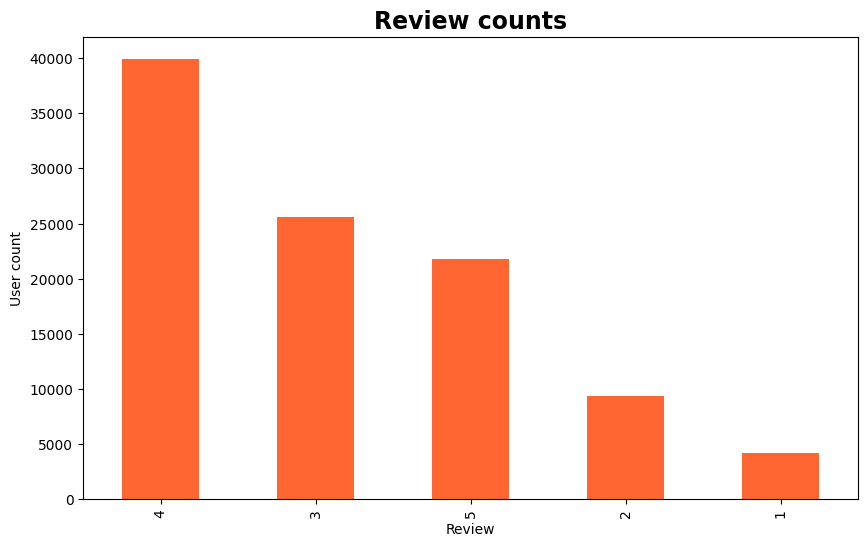

In [ ]:
ratings.rating.apply(lambda x:int(np.ceil(x))).value_counts().plot.bar(figsize=(10,6),color='#FF6631')
plt.title("Review counts",fontweight='bold',fontsize=17)
plt.xlabel("Review")
plt.ylabel("User count")
plt.show()

In [ ]:
ratings['timestamp'] = ratings['timestamp'].map(lambda x: datetime.fromtimestamp(x))

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [ ]:
ratings['timestamp'].describe()

,timestamp
count,100836
mean,2008-03-19 17:01:27.368469248
min,1996-03-29 18:36:55
25%,2002-04-18 09:57:46
50%,2007-08-02 20:31:02
75%,2015-07-04 07:15:44.500000
max,2018-09-24 14:27:30


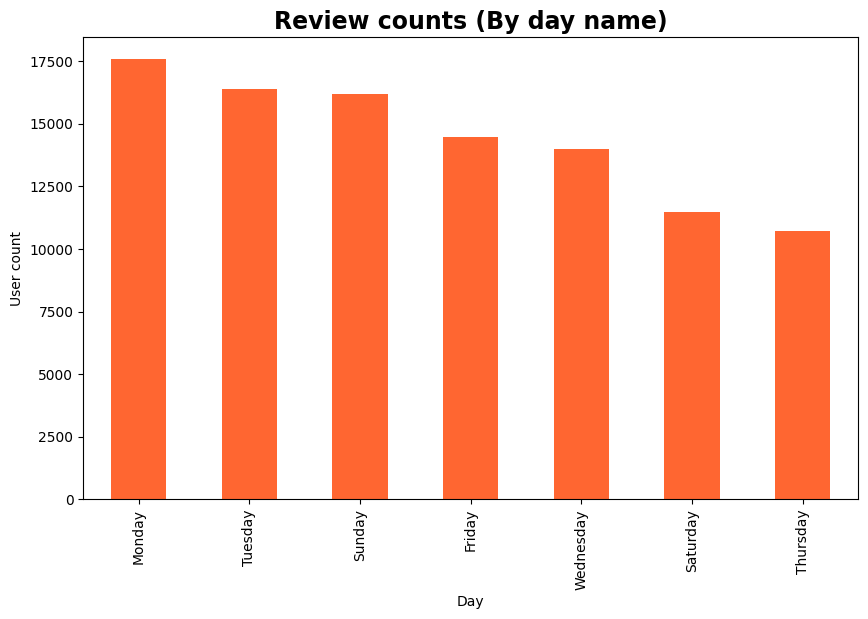

In [ ]:
ratings['timestamp'].dt.day_name().value_counts().plot.bar(color='#FF6631',figsize=(10,6))
plt.title("Review counts (By day name)",fontweight='bold',fontsize=17)
plt.xlabel("Day")
plt.ylabel("User count")
plt.show()

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


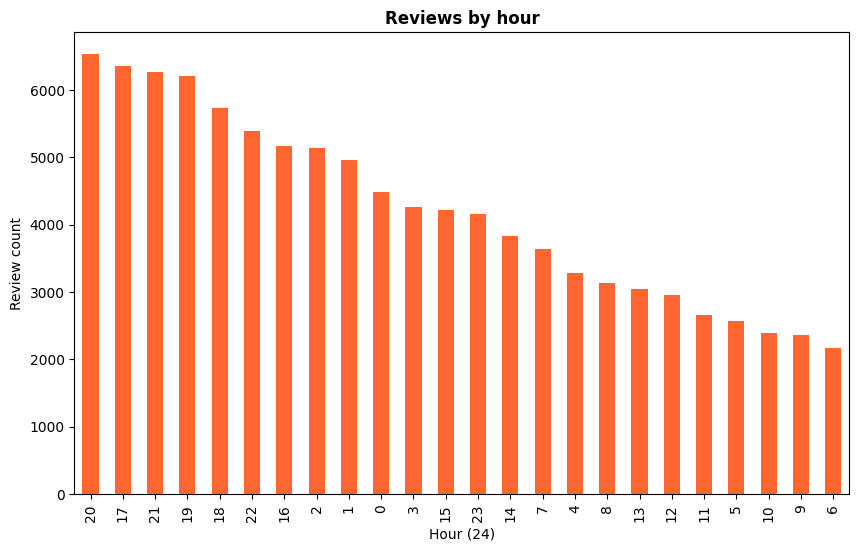

In [ ]:
ratings.timestamp.dt.hour.value_counts().plot.bar(figsize=(10,6),color='#FF6631')
plt.xlabel("Hour (24)")
plt.ylabel("Review count")
plt.title("Reviews by hour",fontweight='bold')
plt.show()

In [ ]:
def get_feature_by_user(df):
    res = list()
    for i, v in tqdm(df.groupby('userId')):
        res.append(
            (
                i,
                len(v['movieId']),
                (v['rating'] == 5).sum(),
                (v['rating'] == 4).sum(),
                (v['rating'] == 3).sum(),
                (v['rating'] == 2).sum(),
                (v['rating'] == 1).sum(),
                (v['timestamp'].dt.dayofweek == 0).sum(),
                (v['timestamp'].dt.dayofweek == 1).sum(),
                (v['timestamp'].dt.dayofweek == 2).sum(),
                (v['timestamp'].dt.dayofweek == 3).sum(),
                (v['timestamp'].dt.dayofweek == 4).sum(),
                (v['timestamp'].dt.dayofweek == 5).sum(),
                (v['timestamp'].dt.dayofweek == 6).sum(),
                (v['timestamp'].dt.hour > 17).sum()

            )
        )

    res = pd.DataFrame(
        res,
        columns=[
            'userId', 'revired_products', '5_star_ratings_gave', '4_star_ratings_gave',
            '3_star_ratings_gave', '2_star_ratings_gave', '1_star_ratings_gave',
            'monday_review_count_user', 'tuesday_review_count_user', 'wednesday_review_count_user', 'thursday_review_count_user',
            'friday_review_count_user', 'saturday_review_count_user', 'sunday_review_count_user', 'evening_reviews_by_user'
        ])
    return res

In [ ]:
def get_feature_by_product(df):
    res = list()
    for i, v in tqdm(df.groupby('movieId')):
        res.append(
            (
                i,
                len(v['userId']),
                (v['rating'] == 5).sum(),
                (v['rating'] == 4).sum(),
                (v['rating'] == 3).sum(),
                (v['rating'] == 2).sum(),
                (v['rating'] == 1).sum(),
                (v['timestamp'].dt.dayofweek == 0).sum(),
                (v['timestamp'].dt.dayofweek == 1).sum(),
                (v['timestamp'].dt.dayofweek == 2).sum(),
                (v['timestamp'].dt.dayofweek == 3).sum(),
                (v['timestamp'].dt.dayofweek == 4).sum(),
                (v['timestamp'].dt.dayofweek == 5).sum(),
                (v['timestamp'].dt.dayofweek == 6).sum(),
                (v['timestamp'].dt.hour > 17).sum()
            )
        )

    res = pd.DataFrame(
        res,
        columns=[
            'movieId', 'user_count', '1_star_ratings_recieved', '2_star_ratings_recieved',
            '3_star_ratings_recieved', '4_star_ratings_recieved', '5_star_ratings_recieved',
            'monday_review_count_item', 'tuesday_review_count_item', 'wednesday_review_count_item', 'thursday_review_count_item',
            'friday_review_count_item', 'saturday_review_count_item', 'sunday_review_count_item', 'evening_reviews_by_movie'
        ])
    return res

In [ ]:
start = min(ratings['timestamp'])
end = max(ratings['timestamp'])
interval = end - start

ratings['rating'] = ratings['rating'].apply(lambda x:int(np.ceil(x)))

train = ratings[ratings['timestamp'] <= (end - interval/3)]
test = ratings[ratings['timestamp'] >= (start + interval/3)]

train_y = train[train['timestamp'] >= (start + interval/3)]
train_X = train[train['timestamp'] < (start + interval/3)]
test_y = test[test['timestamp'] >= (end - interval/3)]
test_X = test[test['timestamp'] < (end - interval/3)]

train_tgt_user = set(train_X['userId']) & set(train_y['userId'])
test_tgt_user = set(test_X['userId']) & set(test_y['userId'])

f"""train_X.shape: {train_X.shape} test_X.shape: {test_X.shape}"""

'train_X.shape: (31960, 4) test_X.shape: (31831, 4)'

In [ ]:
test.timestamp.min(),test.timestamp.max()

(Timestamp('2003-09-28 09:35:27'), Timestamp('2018-09-24 14:27:30'))

In [ ]:
train.timestamp.min(),train.timestamp.max()

(Timestamp('1996-03-29 18:36:55'), Timestamp('2011-03-26 23:42:37'))

In [ ]:
train_X_u = get_feature_by_user(train_X)
test_X_u = get_feature_by_user(test_X)

train_X_p = get_feature_by_product(train_X)
test_X_p = get_feature_by_product(test_X)

100%|██████████| 5418/5418 [00:22<00:00, 238.97it/s]


In [ ]:
def get_model_input(X_u, X_m, y, tgt_users):

    merged = pd.merge(X_u, y, on=['userId'], how='inner')
    merged = pd.merge(X_m, merged, on=['movieId'], how='outer')
    merged = merged.query('userId in @tgt_users')
    # print(merged.columns)

    merged.fillna(0, inplace=True)
    features_cols = list(merged.drop(columns=['userId', 'movieId', 'rating', 'timestamp']).columns)

    query_list = merged['userId'].value_counts()

    merged = merged.set_index(['userId', 'movieId'])

    query_list = query_list.sort_index()

    merged.sort_index(inplace=True)

    df_x = merged[features_cols]

    df_y = merged['rating']

    return df_x, df_y, query_list

X_train, y_train, query_list_train = get_model_input(train_X_u, train_X_p, train_y, train_tgt_user)
X_test, y_test, query_list_test = get_model_input(test_X_u, test_X_p, test_y, test_tgt_user)

<ipython-input-22-38cd8ecbfc98>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.fillna(0, inplace=True)
<ipython-input-22-38cd8ecbfc98>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged.fillna(0, inplace=True)


In [ ]:
from xgboost import XGBRanker

In [ ]:
!pip install xgboost --upgrade  # Upgrade to the latest version of XGBoost

from xgboost import XGBRanker

In [ ]:
model = XGBRanker(objective='rank:ndcg', n_estimators=100, random_state=0, learning_rate=0.1)
model.fit(
    X_train,
    y_train,
    group=query_list_train,
    # eval_metric='ndcg',
    eval_set=[(X_test, y_test)],
    eval_group=[list(query_list_test)],
    verbose=10
)

[0]	validation_0-ndcg@32:0.72822
[10]	validation_0-ndcg@32:0.72175
[20]	validation_0-ndcg@32:0.71908
[30]	validation_0-ndcg@32:0.72123
[40]	validation_0-ndcg@32:0.72633
[50]	validation_0-ndcg@32:0.72504
[60]	validation_0-ndcg@32:0.72281
[70]	validation_0-ndcg@32:0.72543
[80]	validation_0-ndcg@32:0.72525
[90]	validation_0-ndcg@32:0.72660
[99]	validation_0-ndcg@32:0.72694


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None, learning_rate=0.1,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=None, max_leaves=None,
          min_child_weight=None, missing=nan, monotone_constraints=None,
          multi_strategy=None, n_estimators=100, n_jobs=None,
          num_parallel_tree=None, random_state=0, ...)

In [ ]:
query_list_train.shape

(17,)

In [ ]:
len(np.unique(X_train.index.get_level_values(0).values))

17

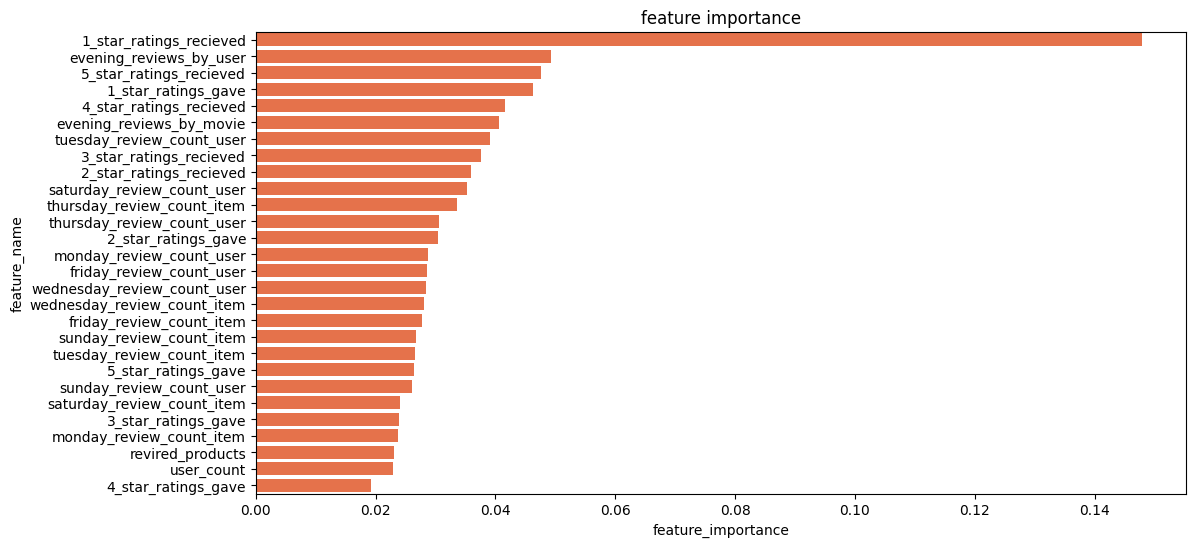

In [ ]:
plt.figure(figsize=(12, 6))
df_plt = pd.DataFrame({'feature_name': X_train.columns, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt, color='#FF6631')
plt.title('feature importance')
plt.show()

In [ ]:
def predict_at_k(data, model, k):
    user_ids = list()
    product_ids = list()
    ranks = list()

    for userId, df in data.groupby('userId'):

        pred = model.predict(df.loc[userId])
        productId = np.array(df.reset_index()['movieId'])
        topK_index = np.argsort(pred)[::-1][:k]
        product_ids.extend(list(productId[topK_index]))
        user_ids.extend([userId]*len(topK_index))
        ranks.extend(list(range(1, len(topK_index)+1)))

    results = pd.DataFrame({'userId': user_ids, 'movieId': product_ids, 'rank': ranks})

    return results

predicted = predict_at_k(X_test, model, 5)

In [ ]:
predicted

,userId,movieId,rank
0,15.0,4720,1
1,15.0,356,2
2,15.0,527,3
3,15.0,70286,4
4,15.0,50872,5
...,...,...,...
89,606.0,72998,1
90,606.0,592,2
91,606.0,1,3
92,606.0,76093,4


In [ ]:
sample = 15.0
print('[predicted]')
print(predicted.query(f'userId == {sample}')[['movieId', 'rank']])
print('+'*20)
print('[actual]')
print(y_test[sample].sort_values(ascending=False))

[predicted]
   movieId  rank
0     4720     1
1      356     2
2      527     3
3    70286     4
4    50872     5
++++++++++++++++++++
[actual]
movieId
5989      5.0
48304     5.0
1270      5.0
4720      5.0
1653      5.0
         ... 
2085      2.0
91529     2.0
5971      2.0
122924    1.0
99114     1.0
Name: rating, Length: 119, dtype: float64


In [ ]:
def coverage(preds,train_X_p):
  test_recs = preds['movieId'].nunique()
  train_movies = train_X_p['movieId'].nunique()

  return test_recs/train_movies

In [ ]:
coverage(predicted,train_X_p)

0.019957424161788185